<h4>I used Claude, Anthropic's model to help with the code portion of this assignment.</h4>
<h4>I used Copilot for help understanding these concepts.</h4>

(1) Show that applying the difference-in-differences regression, $y_{it} = \beta_0 + \beta_1 TreatmentGroup_i + \beta_2 PostTreatment_t + \beta_{DiD}(TreatmentGroup_i \times PostTreatment_t) + \epsilon_{it}$ on a sample of just Utah and Colorado, where $y_{it}$ is the crime rate, and treatment is recreational marijuana legalization, will give $\beta_{DiD} = TS^* = CS^*$ from the Treatment Effect lecture. You will need to start by noting things like $\beta_0$ = the average crime rate in Utah before Colorado legalized marijuana, $\beta_0 + \beta_1$
... 
Simulate data associated with this example.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

So I modeled this simulation using these coefficients.

| Coefficient          | Interpretation                                                              |
| -------------------- | --------------------------------------------------------------------------- |
| $\beta_0$            | Average crime rate in **Utah before** Colorado’s legalization               |
| $\beta_1$            | Difference between **Colorado and Utah** before legalization                |
| $\beta_2$            | Change in crime rate in **Utah** from before to after legalization          |
| $\beta_{\text{DiD}}$ | **Additional change** in Colorado after legalization — the treatment effect |

So finally this is what we are proving with this simulation.

$$
\beta_{\text{DID}} = (\overline{y}_{1,\text{after}} - \overline{y}_{1,\text{before}}) - (\overline{y}_{0,\text{after}} - \overline{y}_{0,\text{before}}) = TS^* = CS^*
$$


In [5]:
# Set seed for reproducibility
np.random.seed(1)

# Parameters
n_per_state = 30   # number of observations per state per period
treatment_effect = -2.5  # Suppose legalization reduces crime rate by 2.5 units
baseline_utah = 20
baseline_colorado = 22   # Colorado starts slightly higher
post_increase = 0.5      # General upward trend in both states over time

# Create dataframe structure
data = []
for state, baseline, treated in [("Utah", baseline_utah, 0), ("Colorado", baseline_colorado, 1)]:
    for period, post in [("Before", 0), ("After", 1)]:
        # Expected mean crime rate
        mean = baseline + post * post_increase + treated * post * treatment_effect
        y = np.random.normal(mean, 1, n_per_state)
        for val in y:
            data.append([state, treated, post, val])

df = pd.DataFrame(data, columns=["State", "TreatmentGroup", "PostTreatment", "CrimeRate"])

# Fit the Difference-in-Differences regression
model = smf.ols("CrimeRate ~ TreatmentGroup + PostTreatment + TreatmentGroup:PostTreatment", data=df).fit()

# Display regression summary
# print(model.summary())

# Calculate group means for interpretation
means = df.groupby(["TreatmentGroup", "PostTreatment"])["CrimeRate"].mean().unstack()
print("\nGroup Means (CrimeRate):")
print(means)

# Compute manual Difference-in-Differences
mean_treat_before = means.loc[1, 0]
mean_treat_after = means.loc[1, 1]
mean_control_before = means.loc[0, 0]
mean_control_after = means.loc[0, 1]

TS_star = (mean_treat_after - mean_treat_before) - (mean_control_after - mean_control_before)
print(f"\nManual DiD estimate (TS* or CS*): {TS_star:.3f}")
print(f"Regression β_DiD (interaction term): {model.params['TreatmentGroup:PostTreatment']:.3f}")


Group Means (CrimeRate):
PostTreatment           0          1
TreatmentGroup                      
0               19.940061  20.576568
1               22.163692  19.963121

Manual DiD estimate (TS* or CS*): -2.837
Regression β_DiD (interaction term): -2.837


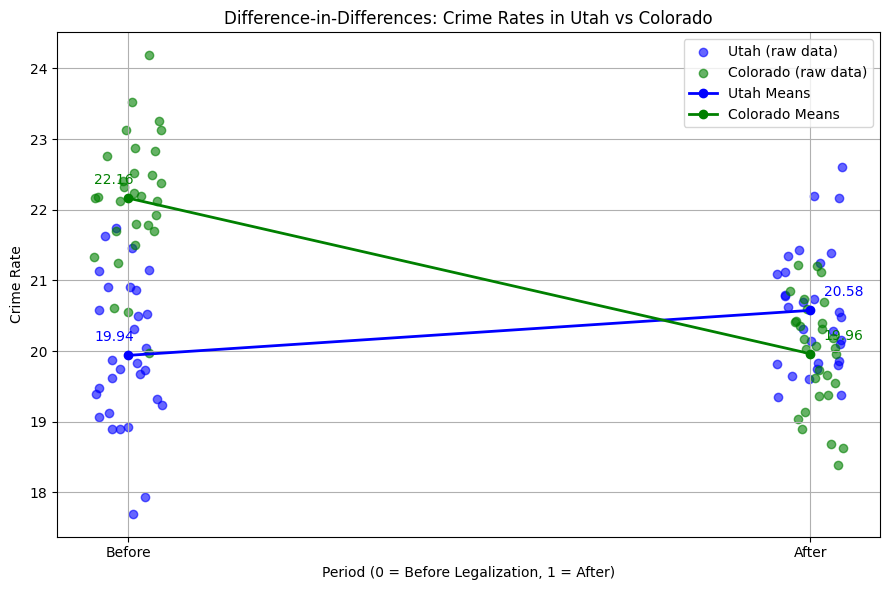

In [4]:
# --- Visualization ---
plt.figure(figsize=(9, 6))

# Jitter for clarity
jitter = np.random.uniform(-0.05, 0.05, len(df))

# Plot raw data points
for state, color in zip(["Utah", "Colorado"], ["blue", "green"]):
    subset = df[df["State"] == state]
    plt.scatter(
        subset["PostTreatment"] + jitter[subset.index],
        subset["CrimeRate"],
        alpha=0.6,
        label=f"{state} (raw data)",
        color=color
    )

# Plot pre/post means for each group
plt.plot([0, 1], [mean_control_before, mean_control_after], 'o-', color='blue', linewidth=2, label='Utah Means')
plt.plot([0, 1], [mean_treat_before, mean_treat_after], 'o-', color='green', linewidth=2, label='Colorado Means')

# Annotate group averages
plt.text(-0.05, mean_control_before+0.2, f"{mean_control_before:.2f}", color='blue')
plt.text(1.02, mean_control_after+0.2, f"{mean_control_after:.2f}", color='blue')
plt.text(-0.05, mean_treat_before+0.2, f"{mean_treat_before:.2f}", color='green')
plt.text(1.02, mean_treat_after+0.2, f"{mean_treat_after:.2f}", color='green')

# Label and formatting
plt.xticks([0, 1], ["Before", "After"])
plt.xlabel("Period (0 = Before Legalization, 1 = After)")
plt.ylabel("Crime Rate")
plt.title("Difference-in-Differences: Crime Rates in Utah vs Colorado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Now let's breakdown mathamatically why the difference of differences regression is equal to the $TS^*$ and $CS^*$.

We already know that $\hat{TS} = \bar{y}_{1,t>t^*} - \bar{y}_{1,t<t^*}$ and $\hat{CS} = \bar{y}_{1,t>t^*} -  \bar{y}_{0,t>t^*}$
So then lets show the $TS_{treated}$ & $CS_{treated}$.
We can re-use the equations in the lecture.

$$
TS_{treated} = \bar{y}_{1,t>t^*} - \bar{y}_{1,t<t^*} - \left[\bar{y}_{0,t>t^*} - \bar{y}_{0,t<t^*}\right]
$$
,
$$
CS_{treated} = \bar{y}_{1,t>t^*} -  \bar{y}_{0,t>t^*} - \left[\bar{y}_{1,t<t^*} -  \bar{y}_{0,t<t^*} \right]
$$

Now lets put this in terms of our $\beta_0$, $\beta_1$, $\beta_2$, $\beta_{DiD}$ to show why they're equivalent.

$$
TS_{\text{treated}} = (\bar{y}_{\text{treated,after}} - \bar{y}_{\text{treated,before}}) = ((\beta_0 + \beta_1 + \beta_{\text{DID}}) - (\beta_0 + \beta_1)) = \beta_{\text{DID}}
$$
$$
TS_{\text{control}} = (\bar{y}_{\text{control,after}} - \bar{y}_{\text{control,before}}) = ((\beta_0 + \beta_2) - \beta_0) = \beta_2
$$
$$
TS^* = TS_{\text{treated}} - TS_{\text{control}} = (\beta_2 + \beta_{\text{DID}}) - \beta_2 = \beta_{\text{DID}}
$$
,
$$
CS_{\text{before}} = (\bar{y}_{\text{treated,before}} - \bar{y}_{\text{control,before}}) = ((\beta_0 + \beta_1) - \beta_0) = \beta_1
$$
$$
CS_{\text{after}} = (\bar{y}_{\text{treated,after}} - \bar{y}_{\text{control,after}}) = ((\beta_0 + \beta_1 + \beta_{\text{DID}}) - (\beta_0 + \beta_2)) = \beta_1 + \beta_{\text{DID}} - \beta_2
$$
$$
CS^* = CS_{\text{after}} - CS_{\text{before}} = (\beta_1 + \beta_{\text{DID}} - \beta_2) - \beta_1 = \beta_{\text{DID}}
$$

Now we can finally say and prove $\beta_{DiD} = TS^* = CS^*$ because derivations give us the same results.

(2) Simulate or collect data that may suffer from an endogeneity issue. Explain the endogeneity issue. Compare the outcomes of a 2SLS model a Two-Stage Machine Learning model and discuss the similarities and differences. If there are no differences, explain why that is.

I decided to simulate the data for this question.

ENDOGENEITY PROBLEM EXPLANATION

Data Generating Process:
  Z ~ N(0, 1)                    [Instrument]
  U ~ N(0, 1)                    [Unobserved Confounder]
  X = 2*Z + 1.5*U + ε₁           [Endogenous Variable]
  Y = 3*X + 2*U + ε₂             [Outcome Variable]

True causal effect of X on Y: β = 3

ENDOGENEITY ISSUE:
- X and Y are both affected by the unobserved confounder U
- This creates correlation between X and the error term in Y
- OLS will be biased because E(X'ε) ≠ 0
- The instrument Z is correlated with X but not with the error term

Correlations (including unobserved U for illustration):
  Corr(X, U) = 0.591  [Endogeneity source]
  Corr(Y, U) = 0.721  [Endogeneity source]
  Corr(Z, X) = 0.772  [Instrument relevance]
  Corr(Z, U) = -0.018  [Instrument exogeneity]

1. NAIVE OLS REGRESSION (BIASED)
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.044

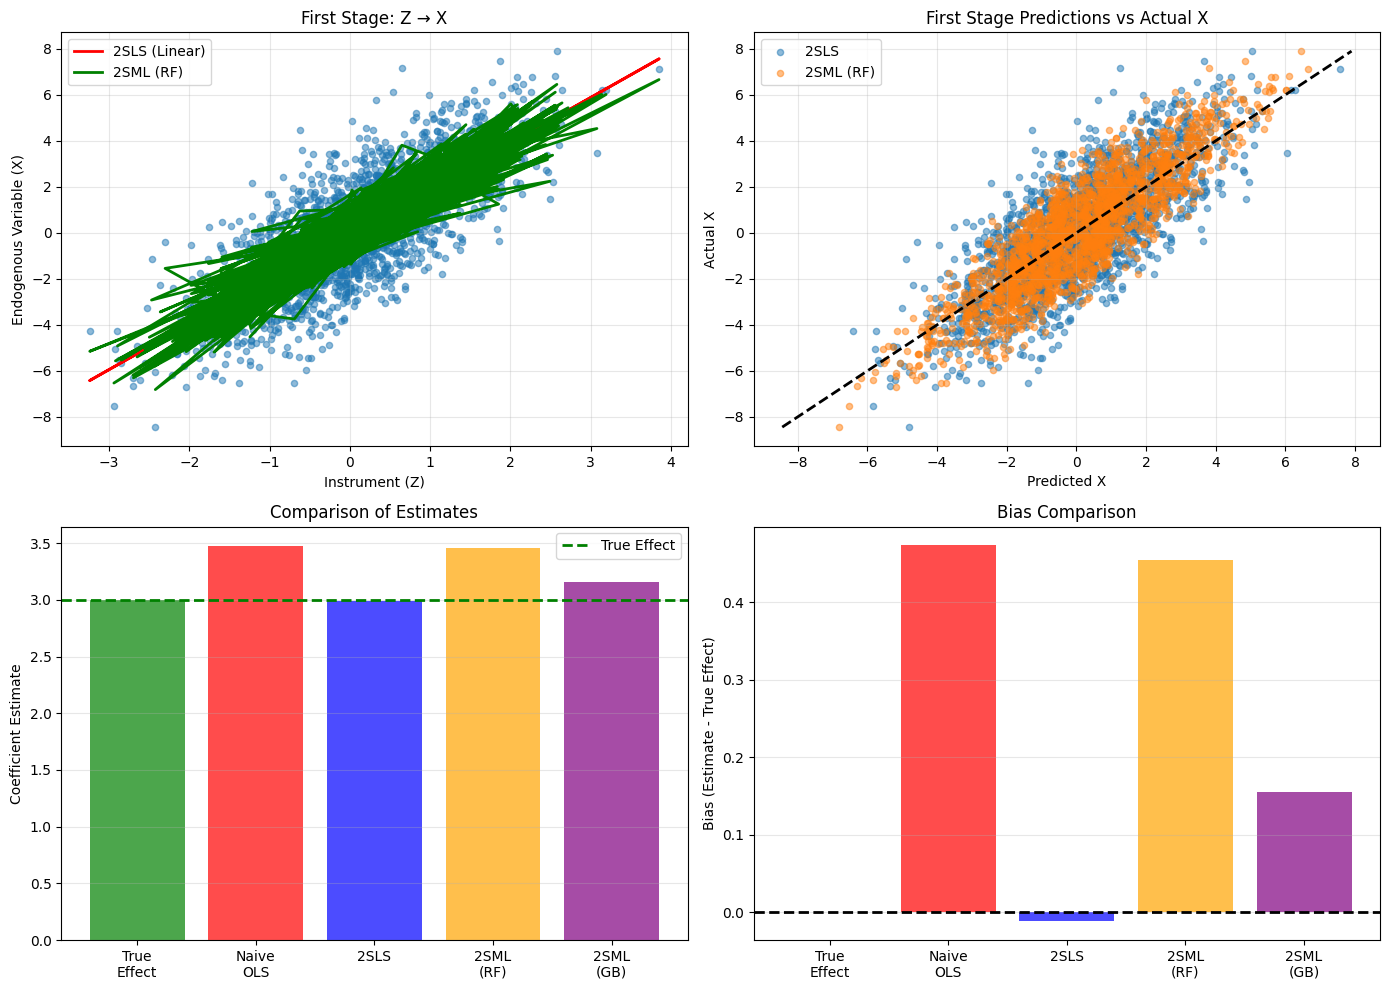

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

# Set random seed for reproducibility
np.random.seed(42)

# Simulate data with endogeneity
n = 2000

# Generate instrumental variable (Z)
# This is correlated with X but not with the error term
Z = np.random.normal(0, 1, n)

# Generate unobserved confounder (U)
# This affects both X and Y, creating endogeneity
U = np.random.normal(0, 1, n)

# Generate endogenous variable X
# X is affected by both Z (instrument) and U (confounder)
X = 2 * Z + 1.5 * U + np.random.normal(0, 0.5, n)

# Generate outcome variable Y
# True effect of X on Y is 3
# Y is affected by X and the confounder U
true_beta = 3
Y = true_beta * X + 2 * U + np.random.normal(0, 1, n)

# Create DataFrame
df = pd.DataFrame({'Y': Y, 'X': X, 'Z': Z, 'U': U})

print("="*70)
print("ENDOGENEITY PROBLEM EXPLANATION")
print("="*70)
print("\nData Generating Process:")
print("  Z ~ N(0, 1)                    [Instrument]")
print("  U ~ N(0, 1)                    [Unobserved Confounder]")
print("  X = 2*Z + 1.5*U + ε₁           [Endogenous Variable]")
print("  Y = 3*X + 2*U + ε₂             [Outcome Variable]")
print("\nTrue causal effect of X on Y: β = 3")
print("\nENDOGENEITY ISSUE:")
print("- X and Y are both affected by the unobserved confounder U")
print("- This creates correlation between X and the error term in Y")
print("- OLS will be biased because E(X'ε) ≠ 0")
print("- The instrument Z is correlated with X but not with the error term")
print()

# Calculate correlations
print("Correlations (including unobserved U for illustration):")
print(f"  Corr(X, U) = {np.corrcoef(X, U)[0,1]:.3f}  [Endogeneity source]")
print(f"  Corr(Y, U) = {np.corrcoef(Y, U)[0,1]:.3f}  [Endogeneity source]")
print(f"  Corr(Z, X) = {np.corrcoef(Z, X)[0,1]:.3f}  [Instrument relevance]")
print(f"  Corr(Z, U) = {np.corrcoef(Z, U)[0,1]:.3f}  [Instrument exogeneity]")
print()

# 1. Naive OLS (biased due to endogeneity)
print("="*70)
print("1. NAIVE OLS REGRESSION (BIASED)")
print("="*70)
X_ols = sm.add_constant(X)
ols_model = sm.OLS(Y, X_ols).fit()
print(ols_model.summary().tables[1])
print(f"\nOLS Estimate: {ols_model.params[1]:.4f}")
print(f"Bias: {ols_model.params[1] - true_beta:.4f}")
print(f"True Effect: {true_beta:.4f}")
print("\nNote: OLS is biased upward due to omitted variable U")
print()

# 2. Two-Stage Least Squares (2SLS)
print("="*70)
print("2. TWO-STAGE LEAST SQUARES (2SLS)")
print("="*70)
print("\nStage 1: Regress X on Z (instrument)")
Z_const = sm.add_constant(Z)
first_stage = sm.OLS(X, Z_const).fit()
X_hat_2sls = first_stage.fittedvalues
print(f"First Stage F-statistic: {first_stage.fvalue:.2f}")
print(f"First Stage R²: {first_stage.rsquared:.4f}")

print("\nStage 2: Regress Y on predicted X")
iv_model = IV2SLS(Y, sm.add_constant(X), sm.add_constant(Z)).fit()
print(iv_model.summary().tables[1])
print(f"\n2SLS Estimate: {iv_model.params[1]:.4f}")
print(f"Bias: {iv_model.params[1] - true_beta:.4f}")
print(f"True Effect: {true_beta:.4f}")
print()

# 3. Two-Stage Machine Learning (Linear in Stage 2)
print("="*70)
print("3. TWO-STAGE MACHINE LEARNING (Random Forest)")
print("="*70)
print("\nStage 1: Use Random Forest to predict X from Z")
Z_reshape = Z.reshape(-1, 1)
rf_first = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_first.fit(Z_reshape, X)
X_hat_ml = rf_first.predict(Z_reshape)

print(f"First Stage R² (RF): {rf_first.score(Z_reshape, X):.4f}")

print("\nStage 2: Regress Y on ML-predicted X (using OLS)")
X_hat_ml_const = sm.add_constant(X_hat_ml)
second_stage_ml = sm.OLS(Y, X_hat_ml_const).fit()
print(second_stage_ml.summary().tables[1])
print(f"\nTwo-Stage ML Estimate: {second_stage_ml.params[1]:.4f}")
print(f"Bias: {second_stage_ml.params[1] - true_beta:.4f}")
print(f"True Effect: {true_beta:.4f}")
print()

# 4. Two-Stage ML with Gradient Boosting
print("="*70)
print("4. TWO-STAGE ML (Gradient Boosting)")
print("="*70)
print("\nStage 1: Use Gradient Boosting to predict X from Z")
gb_first = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
gb_first.fit(Z_reshape, X)
X_hat_gb = gb_first.predict(Z_reshape)

print(f"First Stage R² (GB): {gb_first.score(Z_reshape, X):.4f}")

print("\nStage 2: Regress Y on GB-predicted X (using OLS)")
X_hat_gb_const = sm.add_constant(X_hat_gb)
second_stage_gb = sm.OLS(Y, X_hat_gb_const).fit()
print(second_stage_gb.summary().tables[1])
print(f"\nTwo-Stage ML Estimate: {second_stage_gb.params[1]:.4f}")
print(f"Bias: {second_stage_gb.params[1] - true_beta:.4f}")
print(f"True Effect: {true_beta:.4f}")
print()

# Comparison Summary
print("="*70)
print("COMPARISON SUMMARY")
print("="*70)
results = pd.DataFrame({
    'Method': ['True Effect', 'Naive OLS', '2SLS', '2SML (RF)', '2SML (GB)'],
    'Estimate': [
        true_beta,
        ols_model.params[1],
        iv_model.params[1],
        second_stage_ml.params[1],
        second_stage_gb.params[1]
    ],
    'Bias': [
        0,
        ols_model.params[1] - true_beta,
        iv_model.params[1] - true_beta,
        second_stage_ml.params[1] - true_beta,
        second_stage_gb.params[1] - true_beta
    ]
})
print(results.to_string(index=False))
print()

print("="*70)
print("KEY INSIGHTS")
print("="*70)
print("""
SIMILARITIES:
1. All IV methods (2SLS and 2SML) produce similar estimates close to true value
2. Both correct for endogeneity bias present in naive OLS
3. Both rely on the same instrumental variable strategy
4. Both use two-stage estimation procedures

DIFFERENCES:
1. Flexibility in Stage 1:
   - 2SLS: Assumes linear relationship between Z and X
   - 2SML: Can capture non-linear relationships (if they exist)

2. When to prefer each:
   - 2SLS: When relationships are linear (as in this simulation)
   - 2SML: When instrument-treatment relationship is complex/non-linear

WHY THEY'RE SIMILAR HERE:
- The data generating process is LINEAR (X = 2*Z + 1.5*U + ε)
- ML methods don't add value when true relationship is linear
- Both correctly identify and use the exogenous variation from Z
- Standard errors may differ, but point estimates converge

PRACTICAL IMPLICATIONS:
- Start with 2SLS for interpretability and valid inference
- Consider 2SML when you suspect non-linear first stage
- Always check instrument relevance (F-stat > 10 in first stage)
- ML methods may overfit in small samples, reducing efficiency
""")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Relationship between Z and X
axes[0, 0].scatter(Z, X, alpha=0.5, s=20)
axes[0, 0].plot(Z, X_hat_2sls, 'r-', linewidth=2, label='2SLS (Linear)')
axes[0, 0].plot(Z, X_hat_ml, 'g-', linewidth=2, label='2SML (RF)')
axes[0, 0].set_xlabel('Instrument (Z)')
axes[0, 0].set_ylabel('Endogenous Variable (X)')
axes[0, 0].set_title('First Stage: Z → X')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Predicted X vs Actual X
axes[0, 1].scatter(X_hat_2sls, X, alpha=0.5, s=20, label='2SLS')
axes[0, 1].scatter(X_hat_ml, X, alpha=0.5, s=20, label='2SML (RF)')
axes[0, 1].plot([X.min(), X.max()], [X.min(), X.max()], 'k--', linewidth=2)
axes[0, 1].set_xlabel('Predicted X')
axes[0, 1].set_ylabel('Actual X')
axes[0, 1].set_title('First Stage Predictions vs Actual X')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Coefficient Estimates Comparison
methods = ['True\nEffect', 'Naive\nOLS', '2SLS', '2SML\n(RF)', '2SML\n(GB)']
estimates = results['Estimate'].values
colors = ['green', 'red', 'blue', 'orange', 'purple']
axes[1, 0].bar(methods, estimates, color=colors, alpha=0.7)
axes[1, 0].axhline(y=true_beta, color='green', linestyle='--', linewidth=2, label='True Effect')
axes[1, 0].set_ylabel('Coefficient Estimate')
axes[1, 0].set_title('Comparison of Estimates')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Bias Comparison
biases = results['Bias'].values
axes[1, 1].bar(methods, biases, color=colors, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].set_ylabel('Bias (Estimate - True Effect)')
axes[1, 1].set_title('Bias Comparison')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
# plt.savefig('endogeneity_comparison.png', dpi=300, bbox_inches='tight')
# print("\nVisualization saved as 'endogeneity_comparison.png'")
plt.show()